In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle 
from scipy.spatial import distance 
from sklearn.preprocessing import StandardScaler 
from skimage import measure, feature 
from tqdm.auto import tqdm, trange
import torch
from stedfm.loaders import get_dataset
from stedfm import get_pretrained_model_v2

DEEP_TREE_PATH = "./recursive-clustering-experiment/deep/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
MANUAL_TREE_PATH = "./recursive-clustering-experiment/manual/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
PIXELSIZE = 0.015 # in um
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PER_PROTEIN = False

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Node:
    def __init__(self, cluster_id, depth, data=None):
        self.cluster_id = cluster_id
        self.depth = depth
        self.data = data
        self.parent = None
        self.children = []
    
    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node(cluster_id={self.cluster_id}, depth={self.depth}, children={len(self.children)})"
    
    def __repr__(self):
        return self.__str__()

def print_tree(node, indent=0):
    """Helper function to visualize the tree structure"""
    print("  " * indent + str(node))
    if node.data is not None:
        print("  " * (indent + 1) + f"Data: {node.data}")
    for child in node.children:
        print_tree(child, indent + 1)

def build_tree_from_nested_lists(nested_lists, depth=0, parent_id=0):
    """
    Recursively builds a tree from nested lists.
    
    Args:
        nested_lists: A list that may contain nested lists or data elements
        depth: Current depth in the tree
        parent_id: Cluster ID of the parent node
    
    Returns:
        The root node of the tree
    """
    # Create a root node for the current level
    current_id = parent_id
    root = Node(cluster_id=current_id, depth=depth)
    
    # Process each item in the nested list
    for i, item in enumerate(nested_lists):
        # Assign a unique cluster ID for the current node
        current_id = parent_id * 100 + i + 1
        
        if isinstance(item, list):
            # Recursive case: item is a nested list (cluster)
            child_node = build_tree_from_nested_lists(item, depth + 1, current_id)
            root.add_child(child_node)
            # print(f"child_node: {child_node.parent}")
        else:
            # Base case: item is data
            leaf_node = Node(cluster_id=current_id, depth=depth + 1, data=item)
            root.add_child(leaf_node)
            # print(f"leaf_node: {leaf_node.parent}")
    
    return root

def load_data(data_path: str):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def find_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    
    if not node.children:  # This is a leaf node
        leaves.append(node)
    else:
        for child in node.children:
            find_leaf_nodes(child, leaves)
            
    return leaves

def get_depth_nodes(root, depth):
    for child in root.children:
        if child.depth == depth:
            yield child
        else:
            yield from get_depth_nodes(child, depth)

    

In [3]:
_, _, test_loader = get_dataset(
    name="neural-activity-states",
    transform=None, 
    training=True,
    n_channels=1,
    balance=False,
    batch_size=64
)

dataset = test_loader.dataset 

Processing dataset..: 100%|██████████| 1510/1510 [00:02<00:00, 728.57it/s]


=== NAS dataset ===
(array([0, 1, 2, 3]), array([1545, 1423,  512, 2541]))
(array([0, 1, 2, 3]), array([230, 420, 113, 413]))
(array([0, 1, 2, 3]), array([492, 299, 200, 519]))
Training size: 6021
Validation size: 1176
Test size: 1510




In [4]:
model, config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None,
    mask_ratio=0.0, 
    pretrained=True,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.eval()
model.to(DEVICE)

mask_ratio 0.0
pretrained True
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


LinearProbe(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none

In [5]:
vit_data, manual_data = load_data(DEEP_TREE_PATH), load_data(MANUAL_TREE_PATH)
vit_tree, manual_tree = build_tree_from_nested_lists(vit_data), build_tree_from_nested_lists(manual_data)

In [6]:
def get_handcrafted_features(img, mask):
    # m, M = img.min(), img.max()
    # img = (img - m) / (M - m)
    mask_label, num_proteins = measure.label(mask, return_num=True)
    # print(f"--- {num_proteins} proteins in image ---")
    props = measure.regionprops(mask_label, intensity_image=img)
    coordinates = np.array([p.weighted_centroid for p in props])
    distances = distance.pdist(coordinates) * PIXELSIZE 
    distances = distance.squareform(distances)

    if distances.shape[0] <= 1:
        nn_distances = [30.0]
    else:
        nn_distances = np.sort(distances, axis=1)[:, 1]
    density_proteins = (np.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2
    br = measure.blur_effect(img)
    shannon_entropy = measure.shannon_entropy((img)) 
    foreground_intensity = np.mean(img[mask])
    inverted_mask = np.logical_not(mask)
    background_intensity = np.mean(img[inverted_mask])
    snr = (foreground_intensity - background_intensity) / background_intensity
    features = []
    for prop, density, nn in zip(props, density_proteins, nn_distances):
        if np.isnan(nn):
            nn = 30.0
        label = prop.image 
        min_distance = int(0.08 / PIXELSIZE) // 2 + 1
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)
        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.major_axis_length,
            prop.minor_axis_length,
            prop.solidity,
            density,
            nn,
            len(peaks),
            br,
            shannon_entropy,
            snr
        ])
    return np.array(features)

def get_deep_features(img: np.ndarray, model: torch.nn.Module):
    torch_img = torch.tensor(img[np.newaxis, ...]).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = model.forward_features(torch_img)
        features = features.squeeze().cpu().numpy()
    return features


def get_node_features(node, dataset, model: torch.nn.Module = None, extract_deep: bool = False, per_protein: bool = False):
    try:
        data_idx = [item["dataset-idx"].item() for item in node.data["metadata"]]
    except:
        data_idx = [item["dataset-idx"] for item in node.data["metadata"]]

    imgs = [dataset[idx][0].squeeze().numpy() for idx in data_idx]
    masks = [dataset[idx][1]["mask"] for idx in data_idx]
    conditions = [dataset[idx][1]["condition"] for idx in data_idx]
    handcrafted_features = [] if not per_protein else None
    deep_features = []

    for img, mask in zip(imgs, masks):
        # handcrafted features
        h_features = get_handcrafted_features(img=img, mask=mask)
        if np.any(np.isnan(h_features)):
            print("Woops")
            print(h_features)
            print("\n\n")
        if not per_protein:
            h_features = np.mean(h_features, axis=0)
            handcrafted_features.append(h_features) 
        else:
            if handcrafted_features is None:
                handcrafted_features = h_features
            else:
                handcrafted_features = np.concatenate((handcrafted_features, h_features), axis=0)

        # deep features
        if extract_deep:
            d_features = get_deep_features(img=img, model=model)
            deep_features.append(d_features)

    handcrafted_features = np.array(handcrafted_features)
    deep_features = np.array(deep_features) if extract_deep else None

    return handcrafted_features, deep_features, conditions

In [7]:
def fit_scaler(tree):
    scaler = StandardScaler()
    leaf_nodes = find_leaf_nodes(tree)
    all_features = None
    for node in tqdm(leaf_nodes):
        features, _, conditions = get_node_features(node=node, dataset=dataset, per_protein=PER_PROTEIN)
        if all_features is None:
            all_features = features
        else:
            all_features = np.concatenate((all_features, features), axis=0)
    print(all_features.shape)
    all_features = np.array(all_features)
   
    scaler.fit(all_features)
    scaler.transform(all_features)
    max_features = np.quantile(all_features, axis=0, q=0.90)
    min_features = np.quantile(all_features, axis=0, q=0.10)
    return scaler, max_features, min_features

SCALER, max_features, min_features = fit_scaler(tree=vit_tree)

  0%|          | 0/68 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 68/68 [00:35<00:00,  1.91it/s]

(1510, 13)


## Extracting features

In [8]:
from collections import defaultdict

def extract_features(root, model: torch.nn.Module, extract_deep: bool = True):
    handcrafted_subtypes, deep_subtypes = {}, {}
    handcrafted_features, deep_features = {}, {}
    all_conditions, majority_conditions = {}, defaultdict(str)
    leaf_nodes = find_leaf_nodes(root)
    for node in tqdm(leaf_nodes):
        hfeatures, dfeatures, conditions = get_node_features(node=node, dataset=dataset, model=model, extract_deep=extract_deep, per_protein=PER_PROTEIN)
        unique_conditions, counts = np.unique(conditions, return_counts=True)
        mc = unique_conditions[np.argmax(counts)]
        hfeatures = SCALER.transform(hfeatures)
        avg_hfeatures = np.mean(hfeatures, axis=0)
        handcrafted_subtypes[node.cluster_id] = avg_hfeatures
        handcrafted_features[node.cluster_id] = hfeatures 
        all_conditions[node.cluster_id] = conditions 
        majority_conditions[node.cluster_id] = mc  
        if extract_deep:
            avg_dfeatures = np.mean(dfeatures, axis=0) 
            deep_subtypes[node.cluster_id] = avg_dfeatures
            deep_features[node.cluster_id] = dfeatures

    return {
        "handcrafted_subtypes": handcrafted_subtypes, 
        "handcrafted_features": handcrafted_features, 
        "deep_subtypes": deep_subtypes, 
        "deep_features": deep_features, 
        "conditions": all_conditions,
        "majority_conditions": majority_conditions
    }


In [9]:
root_vit_data = extract_features(root=vit_tree, model=model, extract_deep=True)
root_manual_data = extract_features(root=manual_tree, model=model, extract_deep=True)


  0%|          | 0/68 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
 76%|███████▋  | 52/68 [00:40<00:06,  2.62it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 45/45 [00:46<00:00,  1.03s/it]


In [10]:
vit_deep_subtypes = root_vit_data["deep_subtypes"]
vit_deep_features = root_vit_data["deep_features"]
vit_handcrafted_subtypes = root_vit_data["handcrafted_subtypes"]
vit_handcrafted_features = root_vit_data["handcrafted_features"]

manual_deep_subtypes = root_manual_data["deep_subtypes"]
manual_deep_features = root_manual_data["deep_features"]
manual_handcrafted_subtypes = root_manual_data["handcrafted_subtypes"]
manual_handcrafted_features = root_manual_data["handcrafted_features"]

vit_conditions = root_vit_data["conditions"]
vit_majority_conditions = root_vit_data["majority_conditions"]

manual_conditions = root_manual_data["conditions"]
manual_majority_conditions = root_manual_data["majority_conditions"]


temporary_key = list(vit_deep_subtypes.keys())[0] 
print(vit_deep_subtypes[temporary_key].shape, vit_deep_features[temporary_key].shape, vit_handcrafted_subtypes[temporary_key].shape, vit_handcrafted_features[temporary_key].shape)
print(len(vit_conditions[temporary_key]), len(vit_majority_conditions[temporary_key]))

temporary_key = list(manual_deep_subtypes.keys())[0] 
print(manual_deep_subtypes[temporary_key].shape, manual_deep_features[temporary_key].shape, manual_handcrafted_subtypes[temporary_key].shape, manual_handcrafted_features[temporary_key].shape)
print(len(manual_conditions[temporary_key]), len(manual_majority_conditions[temporary_key]))




(384,) (374, 384) (13,) (374, 13)
374 5
(384,) (16, 384) (13,) (16, 13)
16 5


## KNN classification of embeddings using subtype ID as class

(1510, 9)
Accuracy ViT: 0.7708609271523179
Accuracy Manual: 0.5649867374005305
Random accuracy ViT: 0.01390728476821192
Random accuracy Manual: 0.01856763925729443
Silhouette score ViT: -0.01674579828977585
Silhouette score Manual: -0.2952918288666406


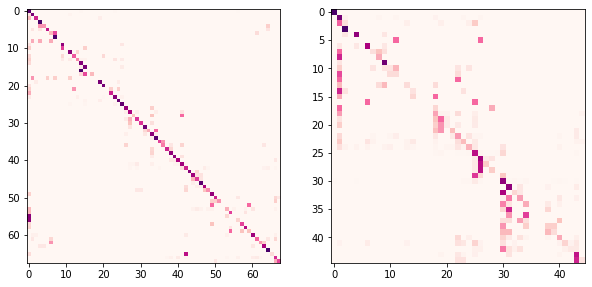

1.0 0.0
1.0 0.0


In [13]:
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

n_neighbors = 9

x = None 
y = []

for i, key in enumerate(vit_deep_features.keys()):
    y += [i] * len(vit_deep_features[key])
    if x is None:
        x = vit_deep_features[key]
    else:
        x = np.concatenate((x, vit_deep_features[key]), axis=0)

y = np.array(y)

pdistances = cdist(x, x, metric="cosine").T 
neighbor_indices = np.argsort(pdistances, axis=1)
neighbors = neighbor_indices[:, 1:n_neighbors+1]
associated_labels = y[neighbors]
print(associated_labels.shape)
uniques = np.unique(y).astype(np.int64)

confusion_matrix_vit = np.zeros((len(uniques), len(uniques)))
for neighbor_labels, truth in zip(associated_labels, y):
        votes, vote_counts = np.unique(neighbor_labels, return_counts=True)
        max_idx = np.argmax(vote_counts)
        max_vote = votes[max_idx]
        vote_count = vote_counts[max_idx]
        if vote_count > 1: # Given our 4-class problems, this should always be true, but useful if ever we do more than 4 classes
            confusion_matrix_vit[truth, max_vote] += 1

# preds = np.array(preds)
accuracy_vit = np.diag(confusion_matrix_vit).sum() / y.shape[0]
# accuracy = np.sum(preds == y) / y.shape[0]

unique_y = np.unique(y) 
random_pred = []
for i in range(x.shape[0]):
    random_pred.append(np.random.choice(unique_y))

random_pred = np.array(random_pred)
random_accuracy_vit = np.sum(random_pred == y) / y.shape[0]

s_score_vit = silhouette_score(x, y, metric="cosine")

######### HANDCRAFTED #################

x = None 
y = []
for i, key in enumerate(manual_handcrafted_features.keys()):
    y += [i] * len(manual_handcrafted_features[key])
    if x is None:
        x = manual_handcrafted_features[key]
    else:
        x = np.concatenate((x, manual_handcrafted_features[key]), axis=0)

y = np.array(y)

pdistances = cdist(x, x, metric="cosine").T 
neighbor_indices = np.argsort(pdistances, axis=1)
neighbors = neighbor_indices[:, 1:n_neighbors+1]
associated_labels = y[neighbors]
uniques = np.unique(y).astype(np.int64)

confusion_matrix_manual = np.zeros((len(uniques), len(uniques)))
for neighbor_labels, truth in zip(associated_labels, y):
        votes, vote_counts = np.unique(neighbor_labels, return_counts=True)
        max_idx = np.argmax(vote_counts)
        max_vote = votes[max_idx]
        vote_count = vote_counts[max_idx]
        if vote_count > 1: # Given our 4-class problems, this should always be true, but useful if ever we do more than 4 classes
            confusion_matrix_manual[truth, max_vote] += 1

accuracy_manual = np.diag(confusion_matrix_manual).sum() / y.shape[0]

unique_y = np.unique(y) 
random_pred = []
for i in range(x.shape[0]):
    random_pred.append(np.random.choice(unique_y))

random_pred = np.array(random_pred)
random_accuracy_manual = np.sum(random_pred == y) / y.shape[0]

s_score_manual = silhouette_score(x, y, metric="cosine")

print(f"Accuracy ViT: {accuracy_vit}")
print(f"Accuracy Manual: {accuracy_manual}")
print(f"Random accuracy ViT: {random_accuracy_vit}")
print(f"Random accuracy Manual: {random_accuracy_manual}")
print(f"Silhouette score ViT: {s_score_vit}")
print(f"Silhouette score Manual: {s_score_manual}")

vit_row_sums = confusion_matrix_vit.sum(axis=1, keepdims=True)
manual_row_sums = confusion_matrix_manual.sum(axis=1, keepdims=True)

confusion_matrix_vit = np.divide(confusion_matrix_vit, vit_row_sums, where=vit_row_sums!=0)
confusion_matrix_manual = np.divide(confusion_matrix_manual, manual_row_sums, where=manual_row_sums!=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(confusion_matrix_vit, cmap="RdPu", vmin=0, vmax=1)
axs[1].imshow(confusion_matrix_manual, cmap="RdPu", vmin=0, vmax=1)
plt.show()

print(confusion_matrix_vit.max(), confusion_matrix_vit.min())
print(confusion_matrix_manual.max(), confusion_matrix_manual.min())

fig.savefig("confusion_matrices.pdf", transparent=True, bbox_inches="tight", dpi=1200)


## Likelihood within leaf nodes

100%|██████████| 45/45 [00:00<00:00, 74.42it/s] 


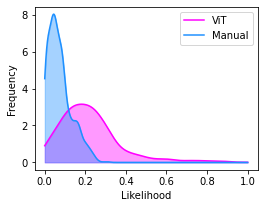

In [14]:
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

def get_likelihood_nn(samples, query_vector, k=5):
    """
    Calculate likelihood using k-nearest neighbors density estimation.
    
    Parameters:
    - samples: Array of shape (n_samples, n_features)
    - query_vector: Array of shape (n_features,)
    - k: Number of nearest neighbors to consider
    """
    # Make sure k is not larger than n_samples
    k = min(k, samples.shape[0])
    
    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(samples)
    distances, _ = nbrs.kneighbors(query_vector.reshape(1, -1))
    
    # Calculate the volume of the hypersphere containing k nearest neighbors
    radius = distances[0][-1]
    volume = np.pi ** (samples.shape[1] / 2) / np.math.gamma(samples.shape[1] / 2 + 1) * radius ** samples.shape[1]
    
    # Density estimate
    likelihood = k / (samples.shape[0] * volume)
    
    return likelihood

def get_kde_likelihood(samples, query_vector):
    query_vector = query_vector[np.newaxis, ...]
    kde = gaussian_kde(samples.T)
    likelihood = kde(query_vector)
    return likelihood

vit_likelihoods = []
manual_likelihoods = []
num_skipped_deep, num_skipped_manual = 0, 0
for key in tqdm(vit_deep_subtypes.keys()):
    samples = vit_deep_features[key]
    samples_reduced = PCA(n_components=2).fit_transform(samples)
    for i in range(samples.shape[0]):
        query_vector = samples_reduced[i, :]
        samples_temp = np.delete(samples_reduced, i, axis=0)
        try:
            ll = get_kde_likelihood(samples_temp, query_vector)[0]
            vit_likelihoods.append(ll)
        except:
            num_skipped_deep += 1
            continue

for key in tqdm(manual_handcrafted_subtypes.keys()):
    samples = manual_handcrafted_features[key]
    samples_reduced = PCA(n_components=2).fit_transform(samples)
    for i in range(samples.shape[0]):
        query_vector = samples_reduced[i, :]
        samples_temp = np.delete(samples_reduced, i, axis=0)
        try:
            ll = get_kde_likelihood(samples_temp, query_vector)[0]
            manual_likelihoods.append(ll)
        except:
            num_skipped_manual += 1
            continue


vit_likelihoods = np.array(vit_likelihoods)
manual_likelihoods = np.array(manual_likelihoods)

vit_kernel = gaussian_kde(vit_likelihoods)
manual_kernel = gaussian_kde(manual_likelihoods)

vit_x = np.linspace(0, 1, len(vit_likelihoods))
manual_x = np.linspace(0, 1, len(manual_likelihoods))
vit_y = vit_kernel(vit_x) #/ len(vit_likelihoods)
manual_y = manual_kernel(manual_x) #/ len(manual_likelihoods)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(vit_x, vit_y, label="ViT", color="fuchsia")
ax.plot(manual_x, manual_y, label="Manual", color="dodgerblue")
ax.fill_between(vit_x, vit_y, color="fuchsia", alpha=0.4)
ax.fill_between(manual_x, manual_y, color="dodgerblue", alpha=0.4)
ax.set_xlabel("Likelihood")
ax.set_ylabel("Frequency")
ax.legend()

## Similarity between leaf nodes (average feature vectors)

In [38]:
def compute_intergraph_node_similarity(data1: dict, data2: dict, feature_key: str = "deep_subtypes", metric: str = "cosine"):
    all_f1, all_f2 = data1[feature_key], data2[feature_key]
    f1 = np.array(list(all_f1.values())) 
    f2 = np.array(list(all_f2.values())) 
    distance_matrix = distance.cdist(f1, f2, metric=metric)
    f1_distances = np.min(distance_matrix, axis=1)
    random_distances = np.random.choice(distance_matrix.ravel(), size=f1_distances.shape[0], replace=False)
    f2_distances = np.min(distance_matrix, axis=0)


    f1_distances_sorted = np.sort(f1_distances)
    f2_distances_sorted = np.sort(f2_distances)
    kernel1 = gaussian_kde(f1_distances)
    kernel2 = gaussian_kde(f2_distances)
    xmax = np.max([np.max(f1_distances_sorted), np.max(f2_distances_sorted)])
    x1 = np.linspace(0, xmax, len(f1_distances_sorted))
    x2 = np.linspace(0, xmax, len(f2_distances_sorted))
    pdf1 = kernel1(x1)
    pdf2 = kernel2(x2)
    random_distances = np.sort(random_distances)
    y1 = np.linspace(0, 1, len(f1_distances_sorted))
    y2 = np.linspace(0, 1, len(f2_distances_sorted))
    yrandom = np.linspace(0, 1, len(random_distances))
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(f1_distances_sorted, y1, label="ViT to manual", color="fuchsia")
    axs[0].plot(f2_distances_sorted, y2, color="dodgerblue", label="Manual to ViT")
    axs[1].plot(x1, pdf1, label="ViT to manual", color="fuchsia")
    axs[1].plot(x2, pdf2, color="dodgerblue", label="Manual to ViT")
    axs[1].fill_between(x1, pdf1, color="fuchsia", alpha=0.4)
    axs[1].fill_between(x2, pdf2, color="dodgerblue", alpha=0.4)
    # axs[0].plot(random_distances, yrandom, color="black", ls="--", label="Random")
    dims = "384D" if feature_key == "deep_subtypes" else "11D"
    axs[0].set_title(f"{feature_key} ({dims})")
    # ax.set_xscale("log")
    plt.legend()
    fig.savefig(f"./supp/intergraph_node_distances_{feature_key}.pdf", dpi=1200, bbox_inches="tight", transparent=True)
    plt.show()

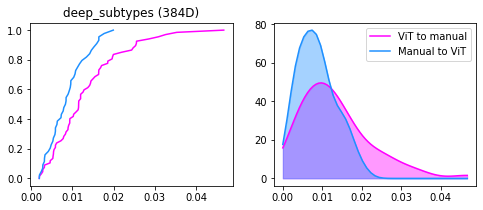

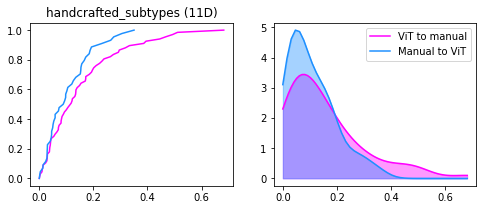

In [39]:
compute_intergraph_node_similarity(root_vit_data, root_manual_data, feature_key="deep_subtypes", metric="cosine")
compute_intergraph_node_similarity(root_vit_data, root_manual_data, feature_key="handcrafted_subtypes", metric="cosine")

**Main takeway**: The ViT-clustered graph has more nodes whose information is not contained in the nodes of the manual-clustered graph, whereas much of the information contained in the nodes of the manual-clustered graph can be retrieved from the nodes of the ViT-clustered graph.

In [46]:
def compute_intragraph_node_similarity(data1: dict, data2: dict, feature_key: str = "deep_subtypes", metric: str = "cosine"):
    all_f1, all_f2 = data1[feature_key], data2[feature_key]
    f1 = np.array(list(all_f1.values())) 
    f2 = np.array(list(all_f2.values())) 
    distance_matrix1 = distance.cdist(f1, f1, metric=metric)
    distance_matrix2 = distance.cdist(f2, f2, metric=metric)

    f1_distances, f2_distances = [], [] 
    for i in range(distance_matrix1.shape[0]):
        distance_row = np.sort(distance_matrix1[i, :])
        d = distance_row[1]
        f1_distances.append(d)
    for i in range(distance_matrix2.shape[0]):
        distance_row = np.sort(distance_matrix2[i, :])
        d = distance_row[1]
        f2_distances.append(d)
    
    f1_distances_sorted = np.sort(f1_distances)
    f2_distances_sorted = np.sort(f2_distances)
    kernel1 = gaussian_kde(f1_distances)
    kernel2 = gaussian_kde(f2_distances)
    xmax = np.max([np.max(f1_distances_sorted), np.max(f2_distances_sorted)])
    x1 = np.linspace(0, xmax, len(f1_distances_sorted))
    x2 = np.linspace(0, xmax, len(f2_distances_sorted))
    pdf1 = kernel1(x1)
    pdf2 = kernel2(x2)
    y1 = np.linspace(0, 1, len(f1_distances_sorted))
    y2 = np.linspace(0, 1, len(f2_distances_sorted))
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(f1_distances_sorted, y1, label="ViT to ViT", color="fuchsia")
    axs[0].plot(f2_distances_sorted, y2, color="dodgerblue", label="Manual to manual")
    axs[1].plot(x1, pdf1, label="ViT to ViT", color="fuchsia")
    axs[1].plot(x2, pdf2, color="dodgerblue", label="Manual to manual")
    axs[1].fill_between(x1, pdf1, color="fuchsia", alpha=0.4)
    axs[1].fill_between(x2, pdf2, color="dodgerblue", alpha=0.4)
    dims = "384D" if feature_key == "deep_subtypes" else "11D"
    axs[0].set_title(f"{feature_key} ({dims})")
    axs[0].set_ylabel("Cumulative sum")
    axs[0].set_xlabel("Nearest node distance")
    # ax.set_xscale("log")
    plt.legend()
    plt.show
    fig.savefig(f"./supp/intragraph_node_distances_{feature_key}.pdf", dpi=1200, bbox_inches="tight", transparent=True)
    

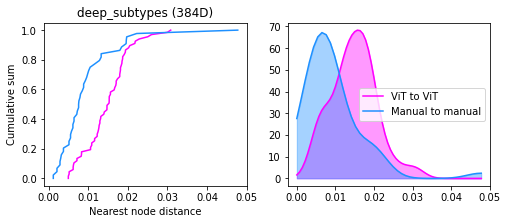

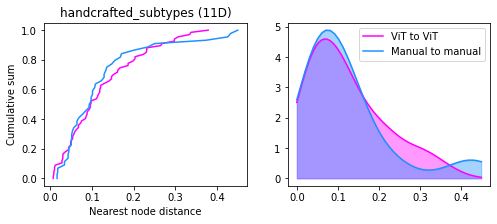

In [47]:
compute_intragraph_node_similarity(root_vit_data, root_manual_data, feature_key="deep_subtypes", metric="cosine")
compute_intragraph_node_similarity(root_vit_data, root_manual_data, feature_key="handcrafted_subtypes", metric="cosine")

**Main takeaway**: Node information in the same graph is more "orthogonal" in the ViT-clustered graph, since nodes muchmust be transported along generally larger distances to the most similar node of the same graph than nodes in the manual-clustered graph

In [48]:
def majority_class_distributions(c1, c2):
    """
    NOTE: Assumes that the ViT-graph conditions are in c1 and the manual-graph conditions in c2
    """
    majorities = defaultdict(list)
    for i, c in enumerate([c1, c2]):
        for key in c.keys():
            current_conditions = c[key]
            cnames, ccounts = np.unique(current_conditions, return_counts=True)
            total = sum(ccounts)
            majority = max(ccounts)
            ratio = majority / total 
            majorities[i].append(ratio)
    
    majority_c1, majority_c2 = list(majorities.values())
    kernel1 = gaussian_kde(majority_c1)
    kernel2 = gaussian_kde(majority_c2)
    xmax = np.max([np.max(majority_c1), np.max(majority_c2)])
    x1 = np.linspace(0, xmax, len(majority_c1))
    x2 = np.linspace(0, xmax, len(majority_c2))
    pdf1 = kernel1(x1)
    pdf2 = kernel2(x2)
    majority_c1_sorted, majority_c2_sorted = np.sort(majority_c1), np.sort(majority_c2)
    y1 = np.linspace(0, 1, len(majority_c1_sorted))
    y2 = np.linspace(0, 1, len(majority_c2_sorted))
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(majority_c1_sorted, y1, color="fuchsia", label="Deep")
    axs[0].plot(majority_c2_sorted, y2, color="dodgerblue", label="Manual")
    axs[0].set_ylabel("Cumulative sum")
    axs[0].set_xlabel("Majority class percentage per node")
    axs[1].plot(x1, pdf1, color="fuchsia", label="Deep")
    axs[1].plot(x2, pdf2, color="dodgerblue", label="Manual")
    axs[1].fill_between(x1, pdf1, color="fuchsia", alpha=0.4)
    axs[1].fill_between(x2, pdf2, color="dodgerblue", alpha=0.4)
    plt.legend()
    plt.show()
    fig.savefig("./supp/majority_class_distributions.pdf", dpi=1200, transparent=True, bbox_inches="tight")


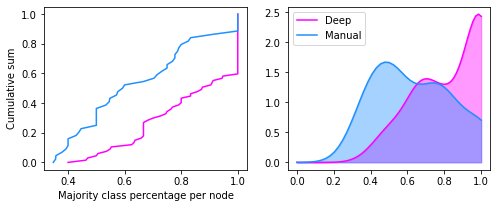

In [49]:
majority_class_distributions(c1=vit_conditions, c2=manual_conditions)

**Main takeaway**: Let's ignore this one

## Mapping vectors from one graph to nodes from another graph (vectors to subytpes)

In [18]:
def compute_mapping_matrix(features, subtypes, c1=None, c2=None, split_regions: bool = False, threshold=0.4):
    ax1_hlines = {}
    ax2_vlines = {}
    if split_regions:
        condition_dict = {c: i for i, c in enumerate(dataset.classes)}
        ax1_keys, ax2_keys = list(features.keys()), list(subtypes.keys())
        ax1_conditions = [c1[key] for key in ax1_keys]
        ax2_conditions = [c2[key] for key in ax2_keys]
        ax1_conditions = np.array([condition_dict[c] for c in ax1_conditions])
        ax2_conditions = np.array([condition_dict[c] for c in ax2_conditions])
        unique_c = np.unique(ax1_conditions)
        sorted_ax1_indices = np.argsort(ax1_conditions)
        sorted_ax2_indices = np.argsort(ax2_conditions)
        sorted_ax1_conditions = ax1_conditions[sorted_ax1_indices]
        sorted_ax2_conditions = ax2_conditions[sorted_ax2_indices]
        for c in unique_c:
            ax1_hlines[c] = np.where(sorted_ax1_conditions == c)[0][-1]
            ax2_vlines[c] = np.where(sorted_ax2_conditions == c)[0][-1]

    subtypes_array = np.array(list(subtypes.values()))
    mapping_matrix = np.zeros((len(list(features.keys())), subtypes_array.shape[0]))
    for k, key in enumerate(features.keys()):
        data = features[key]
        N = data.shape[0]
        mapped_to = [0] * subtypes_array.shape[0]
        for i in range(data.shape[0]):
            vector = data[i][np.newaxis, ...]
            distance_matrix = distance.cdist(vector, subtypes_array, metric="cosine")
            distances = np.argsort(distance_matrix, axis=1)[0]
            mapped_idx = distances[0]
            mapped_to[mapped_idx] += 1 
        mapped_to = [item / N for item in mapped_to]
        mapping_matrix[k] = mapped_to 
    
    if split_regions:
        mapping_matrix = mapping_matrix[sorted_ax1_indices, :]
        mapping_matrix = mapping_matrix[:, sorted_ax2_indices]
    return mapping_matrix, ax1_hlines, ax2_vlines


In [48]:
MAPPED_THRESHOLD = 0.497
LOWER_THRESHOLD = 0.05
UNIQUE_THRESHOLD = 0.4


vit_to_manual_deep, v_to_m_deep_hlines, v_to_m_deep_vlines = compute_mapping_matrix(features=vit_deep_features, subtypes=manual_deep_subtypes, c1=vit_majority_conditions, c2=manual_majority_conditions, split_regions=False)
manual_to_vit_deep, m_to_v_deep_hlines, m_to_v_deep_vlines = compute_mapping_matrix(features=manual_deep_features, subtypes=vit_deep_subtypes, c1=manual_majority_conditions, c2=vit_majority_conditions, split_regions=False)
vit_to_vit_deep, v_to_v_deep_hlines, v_to_v_deep_vlines = compute_mapping_matrix(features=vit_deep_features, subtypes=vit_deep_subtypes, c1=vit_majority_conditions, c2=vit_majority_conditions, split_regions=False)
manual_to_manual_deep, m_to_m_deep_hlines, m_to_m_deep_vlines = compute_mapping_matrix(features=manual_deep_features, subtypes=manual_deep_subtypes, c1=manual_majority_conditions, c2=manual_majority_conditions, split_regions=False)

vit_to_manual_handcrafted, v_to_m_handcrafted_hlines, v_to_m_handcrafted_vlines = compute_mapping_matrix(features=vit_handcrafted_features, subtypes=manual_handcrafted_subtypes, c1=vit_majority_conditions, c2=manual_majority_conditions, split_regions=False)
manual_to_vit_handcrafted, m_to_v_handcrafted_hlines, m_to_v_handcrafted_vlines = compute_mapping_matrix(features=manual_handcrafted_features, subtypes=vit_handcrafted_subtypes, c1=manual_majority_conditions, c2=vit_majority_conditions, split_regions=False)
vit_to_vit_handcrafted, v_to_v_handcrafted_hlines, v_to_v_handcrafted_vlines = compute_mapping_matrix(features=vit_handcrafted_features, subtypes=vit_handcrafted_subtypes, c1=vit_majority_conditions, c2=vit_majority_conditions, split_regions=False)
manual_to_manual_handcrafted, m_to_m_handcrafted_hlines, m_to_m_handcrafted_vlines = compute_mapping_matrix(features=manual_handcrafted_features, subtypes=manual_handcrafted_subtypes, c1=manual_majority_conditions, c2=manual_majority_conditions, split_regions=False)

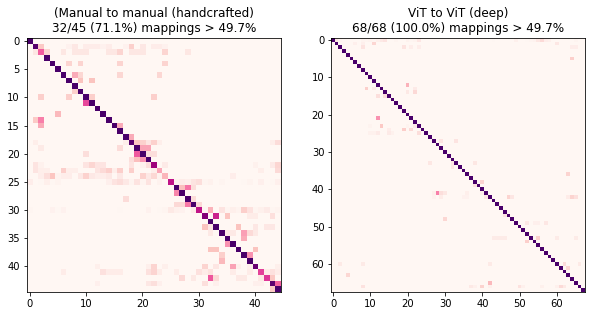

--- ViT to ViT (deep) ---
	 0 0 0.49732620320855614
	 1 1 0.8297872340425532
	 2 2 0.7894736842105263
	 3 3 1.0
	 4 4 1.0
	 5 5 0.9
	 6 6 1.0
	 7 7 1.0
	 8 8 1.0
	 9 9 1.0
	 10 10 1.0
	 11 11 1.0
	 12 12 0.8461538461538461
	 13 13 0.8333333333333334
	 14 14 0.8846153846153846
	 15 15 0.875
	 16 16 1.0
	 17 17 1.0
	 18 18 1.0
	 19 19 1.0
	 20 20 1.0
	 21 21 0.8
	 22 22 1.0
	 23 23 0.8295454545454546
	 24 24 0.7948717948717948
	 25 25 0.8135593220338984
	 26 26 1.0
	 27 27 0.9
	 28 28 1.0
	 29 29 1.0
	 30 30 1.0
	 31 31 1.0
	 32 32 1.0
	 33 33 0.8695652173913043
	 34 34 0.9583333333333334
	 35 35 1.0
	 36 36 0.9090909090909091
	 37 37 1.0
	 38 38 0.9090909090909091
	 39 39 0.9444444444444444
	 40 40 1.0
	 41 41 0.6
	 42 42 0.5606060606060606
	 43 43 1.0
	 44 44 1.0
	 45 45 1.0
	 46 46 1.0
	 47 47 0.9523809523809523
	 48 48 0.9166666666666666
	 49 49 0.8723404255319149
	 50 50 1.0
	 51 51 1.0
	 52 52 1.0
	 53 53 0.7096774193548387
	 54 54 0.9
	 55 55 1.0
	 56 56 1.0
	 57 57 1.0
	 58 58 1.

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(manual_to_manual_handcrafted, cmap="RdPu", vmin=0, vmax=MAPPED_THRESHOLD)
mapped = manual_to_manual_handcrafted > MAPPED_THRESHOLD 
axs[0].set_title(f"(Manual to manual (handcrafted)\n{mapped.sum()}/{manual_to_manual_handcrafted.shape[0]} ({mapped.sum()/manual_to_manual_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")


axs[1].imshow(vit_to_vit_deep, cmap="RdPu", vmin=0, vmax=MAPPED_THRESHOLD)
mapped = vit_to_vit_deep > MAPPED_THRESHOLD 
axs[1].set_title(f"ViT to ViT (deep)\n{mapped.sum()}/{vit_to_vit_deep.shape[0]} ({mapped.sum()/vit_to_vit_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")

plt.show()
fig.savefig("./mapping_matrix_handcrafted.pdf", bbox_inches="tight", transparent=True, dpi=1200)

print("--- ViT to ViT (deep) ---")
for i in range(vit_to_vit_deep.shape[0]):
    max_idx = np.argmax(vit_to_vit_deep[i, :])
    if max_idx != i:
        print(i, max_idx)
    if True: #vit_to_vit_deep[i, max_idx] < MAPPED_THRESHOLD:
        print("\t", i, max_idx, vit_to_vit_deep[i, max_idx])

print("--- Manual to Manual (handcrafted) ---")
for i in range(manual_to_manual_handcrafted.shape[0]):
    max_idx = np.argmax(manual_to_manual_handcrafted[i, :])
    if max_idx != i:
        print(i, max_idx)
    if True: #manual_to_manual_handcrafted[i, max_idx] < MAPPED_THRESHOLD:
        print("\t", i, max_idx, manual_to_manual_handcrafted[i, max_idx])

{'Block': 0, '0MgGlyBic': 1, 'GluGly': 2, '48hTTX': 3}


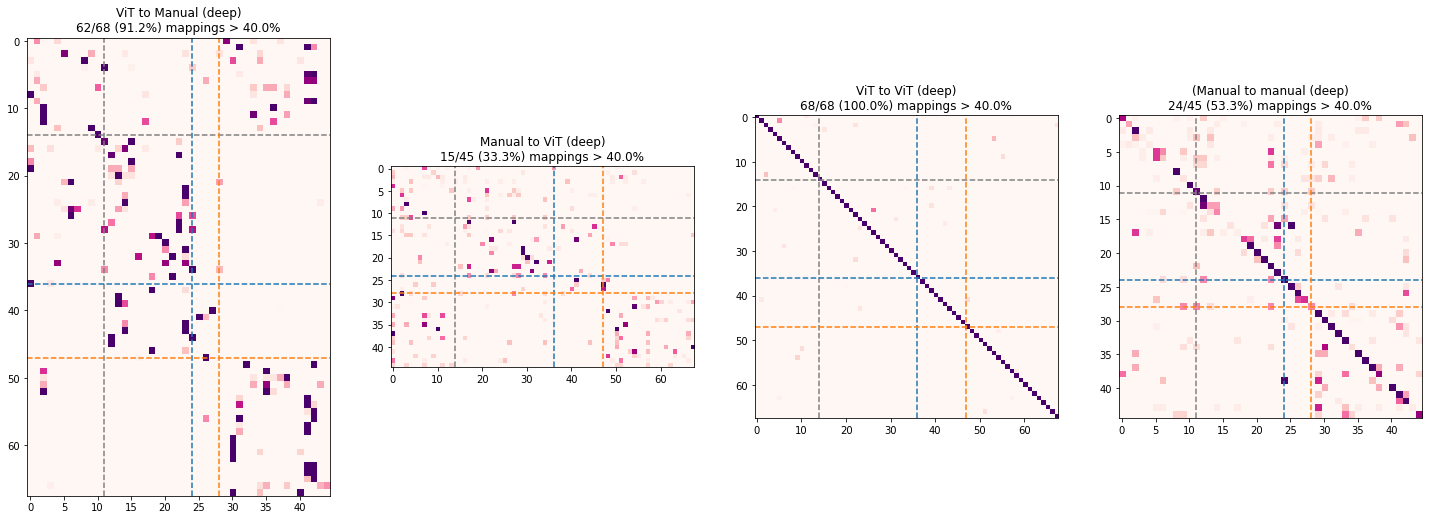

In [21]:
print({c: i for i, c in enumerate(dataset.classes)})
fig, axs = plt.subplots(1, 4, figsize=(25, 10))
axs[0].imshow(vit_to_manual_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_manual_deep > MAPPED_THRESHOLD 
axs[0].set_title(f"ViT to Manual (deep)\n{mapped.sum()}/{vit_to_manual_deep.shape[0]} ({mapped.sum()/vit_to_manual_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_m_deep_hlines.values())[:-1], list(v_to_m_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[0].axhline(h, color=c, ls="--")
    axs[0].axvline(v, color=c, ls="--")

axs[1].imshow(manual_to_vit_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_vit_deep > MAPPED_THRESHOLD 
axs[1].set_title(f"Manual to ViT (deep)\n{mapped.sum()}/{manual_to_vit_deep.shape[0]} ({mapped.sum()/manual_to_vit_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_v_deep_hlines.values())[:-1], list(m_to_v_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[1].axhline(h, color=c, ls="--")
    axs[1].axvline(v, color=c, ls="--")

axs[2].imshow(vit_to_vit_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_vit_deep > MAPPED_THRESHOLD 
axs[2].set_title(f"ViT to ViT (deep)\n{mapped.sum()}/{vit_to_vit_deep.shape[0]} ({mapped.sum()/vit_to_vit_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_v_deep_hlines.values())[:-1], list(v_to_v_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[2].axhline(h, color=c, ls="--")
    axs[2].axvline(v, color=c, ls="--")

axs[3].imshow(manual_to_manual_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_manual_deep > MAPPED_THRESHOLD 
axs[3].set_title(f"(Manual to manual (deep)\n{mapped.sum()}/{manual_to_manual_deep.shape[0]} ({mapped.sum()/manual_to_manual_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_m_deep_hlines.values())[:-1], list(m_to_m_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[3].axhline(h, color=c, ls="--")
    axs[3].axvline(v, color=c, ls="--")
plt.show()

{'Block': 0, '0MgGlyBic': 1, 'GluGly': 2, '48hTTX': 3}


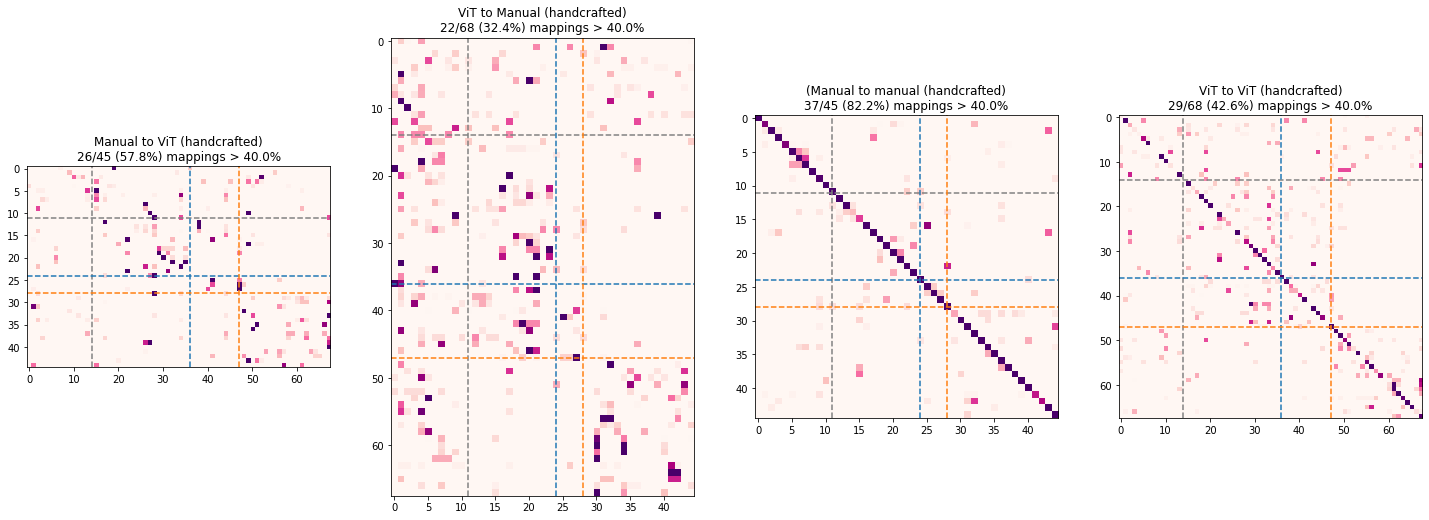

In [22]:

print({c: i for i, c in enumerate(dataset.classes)})

fig, axs = plt.subplots(1, 4, figsize=(25, 10))
axs[0].imshow(manual_to_vit_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_vit_handcrafted > MAPPED_THRESHOLD 
axs[0].set_title(f"Manual to ViT (handcrafted)\n{mapped.sum()}/{manual_to_vit_handcrafted.shape[0]} ({mapped.sum()/manual_to_vit_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_v_handcrafted_hlines.values())[:-1], list(m_to_v_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[0].axhline(h, color=c, ls="--")
    axs[0].axvline(v, color=c, ls="--")

axs[1].imshow(vit_to_manual_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_manual_handcrafted > MAPPED_THRESHOLD 
axs[1].set_title(f"ViT to Manual (handcrafted)\n{mapped.sum()}/{vit_to_manual_handcrafted.shape[0]} ({mapped.sum()/vit_to_manual_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_m_handcrafted_hlines.values())[:-1], list(v_to_m_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[1].axhline(h, color=c, ls="--")
    axs[1].axvline(v, color=c, ls="--")

axs[2].imshow(manual_to_manual_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_manual_handcrafted > MAPPED_THRESHOLD 
axs[2].set_title(f"(Manual to manual (handcrafted)\n{mapped.sum()}/{manual_to_manual_handcrafted.shape[0]} ({mapped.sum()/manual_to_manual_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_m_handcrafted_hlines.values())[:-1], list(m_to_m_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[2].axhline(h, color=c, ls="--")
    axs[2].axvline(v, color=c, ls="--")

axs[3].imshow(vit_to_vit_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_vit_handcrafted > MAPPED_THRESHOLD 
axs[3].set_title(f"ViT to ViT (handcrafted)\n{mapped.sum()}/{vit_to_vit_handcrafted.shape[0]} ({mapped.sum()/vit_to_vit_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_v_handcrafted_hlines.values())[:-1], list(v_to_v_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[3].axhline(h, color=c, ls="--")
    axs[3].axvline(v, color=c, ls="--")

plt.show()

**Main takeaways**:
- From graphs in the 3rd column: subtypes are more well-defined when using deep features. This is observed from the fact that: 
    - the ViT-clustered graph has 100% of nodes for which at least 40% of vectors map back to their subtype node whereas that percentage is only 82% for the manual-clustered graph.

In [23]:
def compute_mapping_proportions(mapping_matrix: np.ndarray, threshold: float, figax=None, **kwargs):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax 
    max_mapping = np.max(mapping_matrix, axis=1)
    N = max_mapping.shape[0]
    unique_ids = np.where(max_mapping <= threshold)[0]
    proportion_unique = len(unique_ids) / N 
    sorted_mappings = np.sort(max_mapping)

    ax.plot(sorted_mappings, np.linspace(0, 1, len(sorted_mappings)), **kwargs)
    return fig, ax

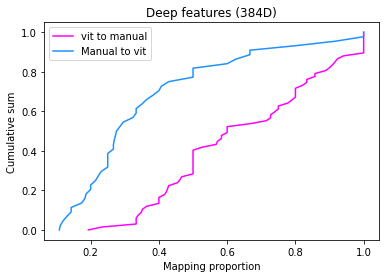

In [32]:
fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_manual_deep, 
    threshold=MAPPED_THRESHOLD, 
    label="vit to manual",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_vit_deep,
    threshold=MAPPED_THRESHOLD,
    label="Manual to vit",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Deep features (384D)")
ax.set_xlabel("Mapping proportion")
ax.set_ylabel("Cumulative sum")
plt.legend()
plt.show()

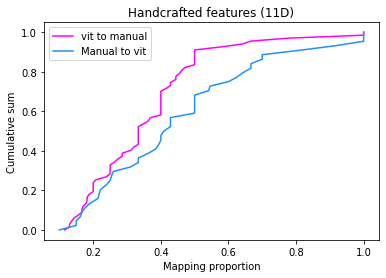

In [33]:
plt.close(fig)

fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_manual_handcrafted, 
    threshold=MAPPED_THRESHOLD, 
    label="vit to manual",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_vit_handcrafted,
    threshold=MAPPED_THRESHOLD,
    label="Manual to vit",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Handcrafted features (11D)")
ax.set_xlabel("Mapping proportion")
ax.set_ylabel("Cumulative sum")
plt.legend()
plt.show()

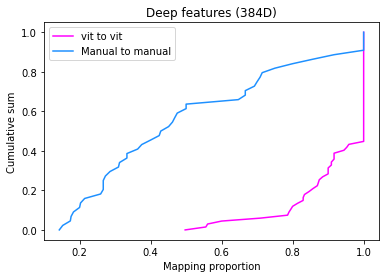

In [35]:
plt.close(fig)

fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_vit_deep,
    threshold=MAPPED_THRESHOLD, 
    label="vit to vit",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_manual_deep,
    threshold=MAPPED_THRESHOLD,
    label="Manual to manual",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Deep features (384D)")
ax.set_xlabel("Mapping proportion")
ax.set_ylabel("Cumulative sum")
plt.legend()
plt.show()

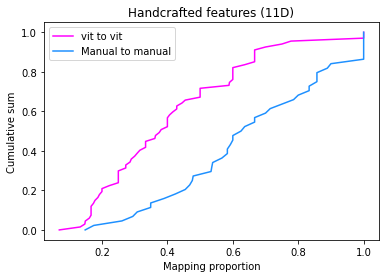

In [36]:
plt.close(fig)

fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_vit_handcrafted,
    threshold=MAPPED_THRESHOLD, 
    label="vit to vit",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_manual_handcrafted,
    threshold=MAPPED_THRESHOLD,
    label="Manual to manual",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Handcrafted features (11D)")
ax.set_xlabel("Mapping proportion")
ax.set_ylabel("Cumulative sum")
plt.legend()
plt.show()